In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch

In [2]:
#find project root
from pathlib import Path
try:
    root = Path(__file__).resolve().parent
except NameError:
    root = Path.cwd()  # fallback for Jupyter notebooks

while root.parent != root:
    if any((root / marker).exists() for marker in ["README.md"]):
        break
    root = root.parent

# Fallback in case nothing found
if not any((root / marker).exists() for marker in ["README.md"]):
    print("Could not locate project root — defaulting to current working directory")
    root = Path.cwd()

root = str(root)
print(f"Root folder detected at: {root}")

Root folder detected at: c:\Users\moeag\Documents\TRAVAIL\EPFL\S3\5_Image processing for earth observation\projet\IPEO-Species-distribution


# Load

In [19]:
env_variables = pd.read_csv('../data/env_variables_training.csv')
env_variables.head()

,surveyId,lon,lat,Bio1,Bio2,Bio3,Bio4,Bio5,Bio6,Bio7,...,Bio10,Bio11,Bio12,Bio13,Bio14,Bio15,Bio16,Bio17,Bio18,Bio19
0,212,3.099038,43.134956,2883,68,3,5545,3007,2780,227,...,2958,2816,6355,933,143,395,2282,770,770,1917
1,222,9.884560,56.912140,2815,59,2,5690,2935,2720,215,...,2890,2746,7286,792,376,201,2283,1336,2076,1653
2,243,8.256020,55.637050,2821,26,1,5150,2910,2741,169,...,2888,2759,8546,1117,372,295,2986,1438,2448,1838
3,324,-0.402590,43.505630,2870,90,3,5315,2992,2756,236,...,2938,2802,10719,1163,564,197,3216,1948,1948,2926
4,333,-0.517360,45.806430,2858,81,3,5285,2982,2758,224,...,2927,2792,9353,1095,503,249,3186,1638,1638,2677


In [18]:
landsat_timeseries = pd.read_csv('../data/landsat_timeseries_training.csv')
landsat_timeseries

,surveyId,landsat_red_2008_1,landsat_red_2008_2,landsat_red_2008_3,landsat_red_2008_4,landsat_red_2009_1,landsat_red_2009_2,landsat_red_2009_3,landsat_red_2009_4,landsat_red_2010_1,...,landsat_nir_2015_3,landsat_nir_2015_4,landsat_nir_2016_1,landsat_nir_2016_2,landsat_nir_2016_3,landsat_nir_2016_4,landsat_nir_2017_1,landsat_nir_2017_2,landsat_nir_2017_3,landsat_nir_2017_4
0,212,7.0,7.0,10.0,8.0,6.0,10.0,11.0,8.0,9.0,...,35.0,28.0,28.0,32.0,35.0,30.0,21.0,34.0,35.0,35.0
1,222,18.0,15.0,23.0,17.0,18.0,11.0,19.0,14.0,18.0,...,99.0,86.0,88.0,94.0,99.0,104.0,91.0,91.0,90.0,87.0
2,243,6.0,9.0,10.0,10.0,6.0,10.0,10.0,10.0,6.0,...,10.0,23.0,24.0,11.0,12.0,20.0,24.0,15.0,12.0,22.0
3,324,23.0,23.0,10.0,15.0,29.0,41.0,18.0,19.0,21.0,...,92.0,74.0,65.0,85.0,90.0,78.0,65.0,83.0,96.0,72.0
4,333,24.0,44.0,26.0,19.0,31.0,17.0,27.0,31.0,20.0,...,86.0,73.0,67.0,90.0,83.0,78.0,68.0,88.0,117.0,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,221730,4.0,11.0,9.0,10.0,4.0,10.0,11.0,9.0,4.0,...,63.0,36.0,46.0,61.0,58.0,43.0,36.0,67.0,62.0,41.0
4996,221746,5.0,7.0,7.0,10.0,5.0,9.0,6.0,7.0,4.0,...,82.0,49.0,39.0,80.0,69.0,62.0,47.0,78.0,81.0,64.0
4997,221783,16.0,12.0,11.0,15.0,16.0,13.0,12.0,15.0,16.0,...,85.0,61.0,58.0,70.0,77.0,57.0,60.0,65.0,86.0,51.0
4998,221846,13.0,13.0,13.0,15.0,13.0,14.0,11.0,19.0,13.0,...,87.0,79.0,69.0,73.0,81.0,73.0,68.0,75.0,86.0,72.0


In [20]:
species_data=np.load('../data/species_data_training.npy')
species_data
species_df=pd.DataFrame(species_data)
species_df

,0,1,2,3,4,5,6,7,8,9,...,332,333,334,335,336,337,338,339,340,341
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4996,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4997,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Text(0.5, 1.0, 'Total species Occurrences for the 5000 samples')

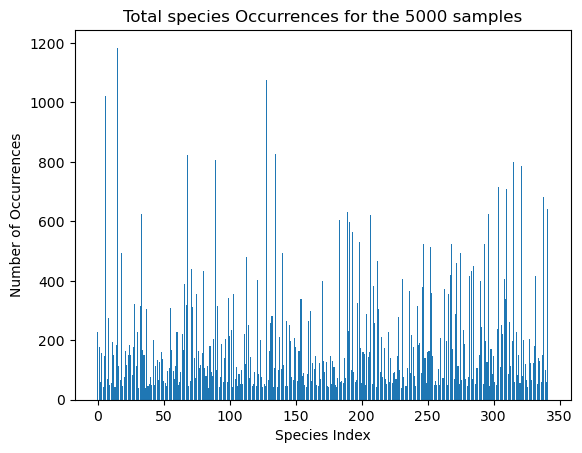

In [32]:
#sum for each column (species)
species_counts=species_df.sum()
species_counts
plt.bar(species_counts.index, species_counts.values)
plt.xlabel('Species Index')
plt.ylabel('Number of Occurrences')
plt.title('Total species Occurrences for the 5000 samples')

In [ ]:
satellite_patches=np.load('/data/satellite_patches_training.npy')
satellite_patches[0]

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\moeag\\Documents\\TRAVAIL\\EPFL\\S3\\5_Image processing for earth observation\\projet\\IPEO-Species-distribution\\data\\satellite_patches_training.npy'

# Map

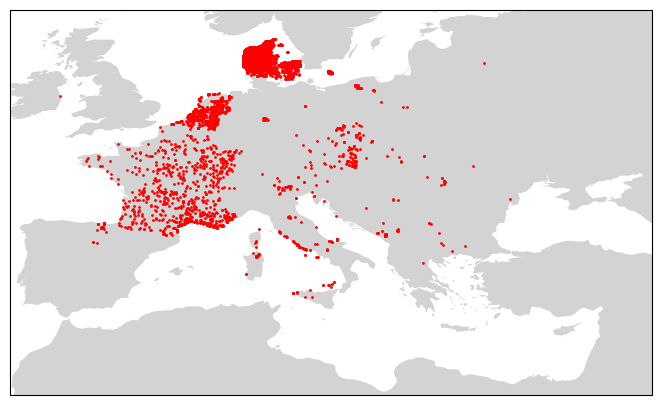

In [26]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_facecolor("white")

ax.add_feature(cfeature.LAND, facecolor="lightgray")
#ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.3)
ax.scatter(env_variables['lon'], env_variables['lat'], color='red', s=1, transform=ccrs.PlateCarree())

ax.set_extent([-10, 40, 30, 60], crs=ccrs.PlateCarree())

plt.show()

# Loading new

In [3]:
import sys
import os

# Ajouter le dossier 'source' au PYTHONPATH
sys.path.append(os.path.abspath("C:\\Users\\moeag\\Documents\\TRAVAIL\\EPFL\\S3\\5_Image processing for earth observation\\projet\\IPEO-Species-distribution"))
from Aurelien_DataLoader.GeoPlantDataset import GeoPlantDataset, viz_sample

In [35]:
root

'c:\\Users\\moeag\\Documents\\TRAVAIL\\EPFL\\S3\\5_Image processing for earth observation\\projet\\IPEO-Species-distribution'

In [4]:
train=GeoPlantDataset(data_folder=f"{root}/data", split='train')

In [7]:
train.env_variables

,surveyId,lon,lat,Bio1,Bio2,Bio3,Bio4,Bio5,Bio6,Bio7,...,Bio10,Bio11,Bio12,Bio13,Bio14,Bio15,Bio16,Bio17,Bio18,Bio19
0,212,3.099038,43.134956,2883,68,3,5545,3007,2780,227,...,2958,2816,6355,933,143,395,2282,770,770,1917
1,222,9.884560,56.912140,2815,59,2,5690,2935,2720,215,...,2890,2746,7286,792,376,201,2283,1336,2076,1653
2,333,-0.517360,45.806430,2858,81,3,5285,2982,2758,224,...,2927,2792,9353,1095,503,249,3186,1638,1638,2677
3,391,6.396106,52.772240,2828,67,3,5423,2945,2731,214,...,2898,2759,9157,921,472,151,2510,1848,2491,2335
4,590,5.028387,51.601834,2835,69,3,5389,2953,2737,216,...,2904,2766,8678,818,492,128,2440,1814,2236,2202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,221681,9.351740,55.237540,2817,57,2,5640,2934,2724,210,...,2890,2748,8798,1039,390,215,2750,1631,2304,2218
3996,221688,10.666360,55.885310,2820,22,1,5510,2913,2740,173,...,2891,2754,5719,612,322,198,1754,1065,1754,1162
3997,221730,6.537502,52.527326,2829,69,3,5528,2949,2731,218,...,2900,2759,8701,865,449,150,2383,1759,2383,2187
3998,221846,9.993730,55.496330,2817,63,2,5788,2942,2722,220,...,2893,2746,6887,741,337,189,2095,1280,1946,1625


# Training

In [ ]:
# neural network with 3 NN (for each modality) and a classifier at the end

class multimodal_SDM (nn.Module): #heritates from class nn.Module
    
    def __init__(self, dim_NN_env=128, dim_NN_sat=4096, dim_NN_timeseries=64): #dimension of output of neural networks
        super(multimodal_SDM, self).__init__()  #call the init of the parent class
        
        self.dim_NN_env=dim_NN_env

        self.dim_NN_sat=dim_NN_sat

        self.dim_NN_timeseries=dim_NN_timeseries
        
        self.MLP_env = nn.Sequential( #19 bioclim variables to 128 values
            nn.Linear(19,50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 128),
            nn.ReLu()
            )
        
        self.CNN_sat= #direct resnet something

        self.CNNtime_series= nn.Sequential( 
            ''' 
            R G B NIR with 10 years and 4 seasons= 40 values: 4 channels, length 40
            Like Alexnet but shorter (2 convolutionnal layers) and in 1D
            ''' 
            nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(32*10, dim_NN_timeseries), # 32 channels * length 10 (2 poolings of size 2 equivalent to divide /4 the length of the input) ?
            nn.ReLU()
        )

        self.classifier= nn.Sequential(
            nn.Linear(dim_NN_env+dim_NN_sat+dim_NN_timeseries, 1000)
            nn.ReLU(),
            nn.Linear(1000, 342)
            nn.Sigmoid()
        )

    def forward (self,x):
        '''x is a GeoPlantDataset object containing the 3 modalities:
        - env_variables
        - satellite_patches
        - landsat_timeseries
        '''
        env_variables=train.env_variables
        satellite_patches=train.satellite_patches
        landsat_timeseries=train.landsat_timeseries

        #pass each modality through its NN
        NN_env_out=self.MLP_env(env_variables)
        NN_sat_out=self.CNN_sat(satellite_patches)
        NN_time_series_out=self.CNN_timeseries(landsat_timeseries)

        #concatenate the outputs
        combined=torch.cat((NN_env_out, NN_sat_out, NN_time_series_out), dim=1)

        #pass through the classifier
        output=self.classifier(combined)
        return output

In [ ]:
batch_size=8
num_epochs=30
model=multimodal_SDM() #default parameters

